## Natural Language Understanding (NLU)
* NLU is an AI subfielf to interpret text and unstructured data
* Applciations: Siri, Alex, Google Assistant

[Reference: Stanford NLU](http://web.stanford.edu/class/cs224u/materials/cs224u-2020-intro-handout.pdf)



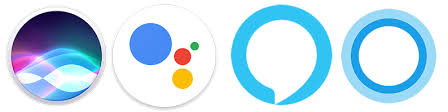

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcR-WiigLm2AB6pCcPjko2-EdhYrtiSdgDFtYQ&usqp=CAU)

### Overview of Chat Bot and Language Assistant

![alt text](https://miro.medium.com/max/2560/1*pbuIMJNy5gqnbHBoUaRsVQ.jpeg)

## Name Entity Recognition (NER)
* Labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names
[References: NER](https://nlp.stanford.edu/software/CRF-NER.html)

![alt text](https://miro.medium.com/max/2972/1*7DkqpU3E-E9yknyw9c7vCQ.png)

## Bidirectional-LSTM-CRF model
![alt text](https://raw.githubusercontent.com/scofield7419/sequence-labeling-BiLSTM-CRF/master/snapshot/BiLSTM_CRF.png)

**Composed of:**
* [Word Embedding](https://lilianweng.github.io/lil-log/2017/10/15/learning-word-embedding.html)
* [Bidirection Long-Short-Term-Memory](https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/)
* [Conditional Random Field](https://people.cs.umass.edu/~mccallum/papers/crf-tutorial.pdf)

[Reference: Bidirectional LSTM for Sequence Tagging](https://arxiv.org/abs/1508.01991)

### Import dependenceis

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

In [ ]:
!git clone https://github.com/DSC-UTDallas/explore-ml.git -b advanced
!mv explore-ml explore_ml
!mv explore_ml/BiLSTM-CRF explore_ml/BiLSTM_CRF

Cloning into 'explore-ml'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 391 (delta 49), reused 61 (delta 22), pack-reused 272
Receiving objects: 100% (391/391), 35.90 MiB | 44.67 MiB/s, done.
Resolving deltas: 100% (146/146), done.
mv: cannot stat 'explore_ml/BiLSTM-CRF': No such file or directory


In [ ]:
from explore_ml.BiLSTM_CRF.src.utils import SentenceGetter
from explore_ml.BiLSTM_CRF.src.model import bilstm_crf, embedding_layer, CRF

### Download data

In [ ]:
!wget https://github.com/DSC-UTDallas/explore-ml/raw/master/name-entity-recognition-corpus.zip
!unzip name-entity-recognition-corpus.zip

--2020-09-10 00:21:22--  https://github.com/DSC-UTDallas/explore-ml/raw/master/name-entity-recognition-corpus.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DSC-UTDallas/explore-ml/master/name-entity-recognition-corpus.zip [following]
--2020-09-10 00:21:22--  https://raw.githubusercontent.com/DSC-UTDallas/explore-ml/master/name-entity-recognition-corpus.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27703149 (26M) [application/zip]
Saving to: ‘name-entity-recognition-corpus.zip.1’

name-entity-recogni 100%[===================>]  26.42M  54.9MB/s    in 0.5s    

2020-09-10 00:21:23 (54.9

### Import corpus

In [ ]:
data = pd.read_csv('ner_dataset.csv', encoding = 'latin1')
data = data.fillna(method="ffill")

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


#### Build Dictionary of Words and Tags

###### Build list of distinct words

In [ ]:
# build list of distinct words
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words 

35179

###### Build list of distinct tags

In [ ]:
# build list of distinct tags
tags = list(set(data["Tag"].values))
n_tags = len(tags);
print("Tags: ", tags)

Tags:  ['B-geo', 'I-geo', 'B-org', 'I-org', 'I-eve', 'B-art', 'I-tim', 'B-nat', 'I-art', 'I-per', 'I-nat', 'B-per', 'I-gpe', 'B-tim', 'O', 'B-eve', 'B-gpe']


###### Build dictionary of words and tags

In [ ]:
# build dictionary of words and tags
max_len = 75
word2dix = {w : i + 1 for i, w in enumerate(words)}
tag2dix = {t : i for i, t in enumerate(tags)}

In [ ]:
word2dix['Obama']

20566

In [ ]:
tag2dix['O']

14

### Generate Sentence Getter

In [ ]:
batch_size = 32
getter = SentenceGetter(data = data, words = words, tags = tags, maxlen = max_len, batch_size = batch_size)

In [ ]:
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

##### Tokenize and pad sentences

In [ ]:
# tokenize : split a sentence into words
# pad_sequences : pad all sentences with trivial values in order to ensure size-consistency of samples in a batch
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = [[word2dix[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = 0)

In [ ]:
print("Pad size: ", X[0].shape)
print("Numerated sequences\n", X[0])

Pad size:  (75,)
Numerated sequences
 [35040 17481 13000 23516 17060 13383 16827  8634 31378 29419  5473  6611
  1206  7752 31117 29419 18132 17481 34715   376 19760 25629 19325 10076
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


In [ ]:
y = [[tag2dix[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2dix["O"])

In [ ]:
print("Tags: ", tags)
print("Numerated tags of a sequence\n", y[0])

Tags:  ['B-geo', 'I-geo', 'B-org', 'I-org', 'I-eve', 'B-art', 'I-tim', 'B-nat', 'I-art', 'I-per', 'I-nat', 'B-per', 'I-gpe', 'B-tim', 'O', 'B-eve', 'B-gpe']
Numerated tags of a sequence
 [14 14 14 14 14 14  0 14 14 14 14 14  0 14 14 14 14 14 16 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14]


### Build BiLSTM-CRF model

In [ ]:
"""
from tensorflow.keras.layers import Input, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras import Model
def bilstm_crf(maxlen, n_tags, embedding_dim, n_words, mask_zero, training = True):
    '''
    bilstm_crf - module to build BiLSTM-CRF model
    Inputs:
        - input_shape : tuple
            Tensor shape of inputs, excluding batch size
    Outputs:
        - output : tensorflow.keras.outputs.output
            BiLSTM-CRF output
    '''
    input = Input(shape = (maxlen,))
    # Embedding layer
    embeddings = embedding_layer(input_dim = n_words + 1, output_dim = embedding_dim, input_length = maxlen, mask_zero = mask_zero)
    output = embeddings(input)

    # BiLSTM layer
    output = Bidirectional(LSTM(units = 50, return_sequences = True, recurrent_dropout = 0.1))(output)

    # CRF layer
    output = TimeDistributed(Dense(n_tags, activation = 'relu'))(output)
    output = CRF(n_tags, name = 'crf_layer')(output)
    return Model(input, output)
"""

"\nfrom tensorflow.keras.layers import Input, Bidirectional, LSTM, TimeDistributed, Dense\nfrom tensorflow.keras import Model\ndef bilstm_crf(maxlen, n_tags, embedding_dim, n_words, mask_zero, training = True):\n    '''\n    bilstm_crf - module to build BiLSTM-CRF model\n    Inputs:\n        - input_shape : tuple\n            Tensor shape of inputs, excluding batch size\n    Outputs:\n        - output : tensorflow.keras.outputs.output\n            BiLSTM-CRF output\n    '''\n    input = Input(shape = (maxlen,))\n    # Embedding layer\n    embeddings = embedding_layer(input_dim = n_words + 1, output_dim = embedding_dim, input_length = maxlen, mask_zero = mask_zero)\n    output = embeddings(input)\n\n    # BiLSTM layer\n    output = Bidirectional(LSTM(units = 50, return_sequences = True, recurrent_dropout = 0.1))(output)\n\n    # Dense layer\n    output = TimeDistributed(Dense(n_tags, activation = 'relu'))(output)\n    \n    output = CRF(n_tags, name = 'crf_layer')(output)\n    return Mo

In [ ]:
model = bilstm_crf(maxlen = max_len, n_tags = n_tags, embedding_dim = 20, n_words = n_words, mask_zero = True)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 17)            1717      
_________________________________________________________________
crf_layer (CRF)              (None, 75, 17)            289       
Total params: 734,006
Trainable params: 734,006
Non-trainable params: 0
_________________________________________________________________


#### Configure and train model

#### Configure hyperparameters: Learning Rate, CRF_Loss, Viberti Accuracy

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.01), loss = model.layers[-1].loss, metrics = model.layers[-1].accuracy)

#### Configure Logging, Checkpoint, Reduce_LR, Early_Stopping

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
logging = TensorBoard(log_dir = './logs/' + 'version_1')
checkpoint = ModelCheckpoint('logs' + '/v1/ep{epoch:03d}-oss{loss:.3f}.h5', monitor = 'loss', save_weights_only = True, save_best_only = True, period = 3)
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 5, verbose = 1)
early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 10, verbose = 1)

#### Train model

In [ ]:
steps_per_epoch = getter.__len__() / 4
model.fit(getter, epochs = 1, initial_epoch = 0, steps_per_epoch=steps_per_epoch, callbacks = [logging, checkpoint, reduce_lr], verbose = 1, shuffle = True)

375/374 [==============================] - 323s 861ms/step - loss: 10.3008 - viterbi_accuracy: 0.9372


### Save mode for Fine-Tunning and Deployment

In [ ]:
# save weights
model.save_weights('saved_model/bilstm_crf_weights/sequence_tagger')
# save model for deployment
model.save('saved_model/bilstm_crf_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/bilstm_crf_model/assets


### In-depth Details of Bi-LSTM-CRF

#### Word Embedding

##### Past method for Text Representation: One-Hot Encoding
![alt text](https://hackernoon.com/images/yop32ir.jpg)

In [ ]:
# One-Hot Encoding for "I want to join DSC"
example = ['I', 'want', 'to', 'join', 'DSC']

# word2dix encoding
for i in range(len(example)):
  if example[i] in word2dix.keys():
    example[i] = word2dix[example[i]]
  else:
    example[i] = -1

print("word2dix encoding", example)

# convert to one-hots
processed = []
for token in example:
  x = [0] * len(word2dix)
  if token > 0:
    x[token] = 1
  processed.append(x)

processed = np.array(processed)
print('One-hot-encoded sequence', processed, "and its shape", processed.shape)

print("Problem:\n * Big matrix -> Large computations \n * Sparse matrix -> effect to model performance")

word2dix encoding [11331, 25555, 8634, 3098, -1]
One-hot-encoded sequence [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] and its shape (5, 35179)
Problem:
 * Big matrix -> Large computations 
 * Sparse matrix -> effect to model performance


##### Current Text Representation: Word Embedding
![alt text](https://journals.plos.org/plosone/article/figure/image?download&size=large&id=info:doi/10.1371/journal.pone.0231189.g008)

In [ ]:
# embeddings
embedding_size = 4
embeddings = np.array([np.array([np.random.rand() for _ in range(embedding_size)]) for _ in range(processed.shape[0])])
print("Word embeddings\n", embeddings, "and its shape", embeddings.shape)

Word embeddings
 [[0.6782384  0.41156225 0.61491966 0.95841285]
 [0.57615846 0.4623422  0.43293438 0.5905533 ]
 [0.74720272 0.08532538 0.43009563 0.94390402]
 [0.80759978 0.5544003  0.37381653 0.27397512]
 [0.33949399 0.56357281 0.22235352 0.35397393]] and its shape (5, 4)


#### Bidirectional Long-Short-Term-Memory


![alt text](https://miro.medium.com/max/913/1*B5NHtY8_Y4we0DE4Y-acBA.png)

**Keys:**
* Model runs through sentence forward Past-to-Future and backward Future-to-Past. This extracts more text context that the model can learn both the past and future features.

![alt text](https://miro.medium.com/max/794/1*wODEqmbZyAPH4lihCgpjdQ.gif)


![alt text](https://miro.medium.com/max/913/1*hOESDAR5XsIGtdUk13rcmg.jpeg)
**LSTM**:
* Forget Gate: decide which info of the past info to be forgotten
* Update Gate: update info on the past and previous info
* Output Gate: make predictions

#### Conditional Random Field

![alt text](https://miro.medium.com/max/681/1*8hOWH7YF5INMF2OPhKjVxA.png)

![alt text](https://miro.medium.com/max/8048/1*IPU1I5R9n22Ogq-NhnsOdA.jpeg)

CFR is the combination of **Linear-Chain CRF** and **Viberti Algorithm** (named after Dr. Viberti, founder of Viberti Engineering School of USC).
* **Linear-Chain CRF** is a Statistical algorithm that consider dependent relationships. This means that each word is determined by **the current inpt and the past info/words** by matrix multiplication.
* **Viberti Algorithm** is a Dynamic Programming to accelerate the **Linear-Chain CRF**

![alt text](https://lh3.googleusercontent.com/proxy/zwcIWtWzdpgMCkmuRw3QRDMgc_Vout-RzyL2LJB3cqfQE1a1VYJ9JcaAhL_eJgMQPD5Ujtj1oKs8-voLZi57REG9HYeNOZlfUc9P1SuvRARCJuikK68OYcpTQn93v1rUo6o1KQ)

### Make predictions

## Deploy on AWS SageMaker

In [ ]:
loaded = tf.saved_model.load('saved_model/bilstm_crf_model')
print("Signature Keys", list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print("Outputs", infer.structured_outputs)

Signature Keys ['serving_default']
Outputs {'crf_layer': TensorSpec(shape=(None, 75, 17), dtype=tf.float32, name='crf_layer')}


## References:
Please look at repo: https://github.com/DSC-UTDallas/explore-ml/tree/advanced